# Fine-Tuning Language Models

This notebook is a supplementary material for the Fine-Tuning Language Models of the [Hands-On Generative AI with Transformers and Diffusion Models book](https://learning.oreilly.com/library/view/hands-on-generative-ai/9781098149239/). This notebook includes:

* The code from the book
* Additional examples
* Exercise solutions

## Classifying Text


In [4]:
import datasets
import numpy as np
import torch
import transformers

np.set_printoptions(edgeitems=10, linewidth=70)
torch.set_printoptions(edgeitems=10, linewidth=70)


transformers.logging.set_verbosity_warning()
datasets.logging.set_verbosity_error()

### Identify a Dataset


In [5]:
from datasets import load_dataset

raw_datasets = load_dataset("ag_news")
raw_datasets

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [6]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

In [7]:
print(raw_train_dataset.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)}


### Preprocess the Dataset

In [8]:
from transformers import AutoTokenizer

checkpoint = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(batch):
    return tokenizer(
        batch["text"], truncation=True, padding=True, return_tensors="pt"
    )


tokenize_function(raw_train_dataset[:2])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': tensor([[  101,  2813,  2358,  1012,  6468, 15020,  2067,  2046,
          1996,  2304,  1006, 26665,  1007, 26665,  1011,  2460,
          1011, 19041,  1010,  2813,  2395,  1005,  1055,  1040,
         11101,  2989,  1032,  2316,  1997, 11087,  1011, 22330,
          8713,  2015,  1010,  2024,  3773,  2665,  2153,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101, 18431,  2571,  3504,  2646,  3293, 13395,  1006,
         26665,  1007, 26665,  1011,  2797,  5211,  3813, 18431,
          2571,  2177,  1010,  1032,  2029,  2038,  1037,  5891,
          2005,  2437,  2092,  1011, 22313,  1998,  5681,  1032,
          6801,  3248,  1999,  1996,  3639,  3068,  1010,  2038,
          5168,  2872,  1032,  2049, 29475,  2006,  2178,  2112,
          1997,  1996,  3006,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 

In [9]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7600
    })
})

### Define evaluation metrics


In [10]:
import evaluate

accuracy = evaluate.load("accuracy")
print(accuracy.description)
print(accuracy.compute(references=[0, 1, 0, 1], predictions=[1, 0, 0, 1]))


Accuracy is the proportion of correct predictions among the total number of cases processed. It can be computed with:
Accuracy = (TP + TN) / (TP + TN + FP + FN)
 Where:
TP: True positive
TN: True negative
FP: False positive
FN: False negative

{'accuracy': 0.5}


In [11]:
f1_score = evaluate.load("f1")


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute accuracy and F1 Score
    acc_result = accuracy.compute(references=labels, predictions=preds)
    acc = acc_result["accuracy"]

    f1_result = f1_score.compute(
        references=labels, predictions=preds, average="weighted"
    )
    f1 = f1_result["f1"]

    return {"accuracy": acc, "f1": f1}

### Train the Model


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

from genaibook import get_device

device = get_device()
num_labels = 4
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=num_labels
).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

batch_size = 32  # You can change this if you have a big or small GPU
training_args = TrainingArguments(
    "classifier-chapter4",
    push_to_hub=True,
    num_train_epochs=2,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
)

In [ ]:
from transformers import Trainer

# Shuffle the dataset and pick 10,000 examples for training
shuffled_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_split = shuffled_dataset.select(range(10000))

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_split,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

  0%|          | 0/626 [00:00<?, ?it/s]

  0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 0.26820164918899536, 'eval_accuracy': 0.911578947368421, 'eval_f1': 0.9113116366931407, 'eval_runtime': 14.5833, 'eval_samples_per_second': 521.144, 'eval_steps_per_second': 16.32, 'epoch': 1.0}
{'loss': 0.3048, 'grad_norm': 2.9898579120635986, 'learning_rate': 1.0063897763578276e-05, 'epoch': 1.6}


  0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 0.24525779485702515, 'eval_accuracy': 0.921578947368421, 'eval_f1': 0.9215476836025032, 'eval_runtime': 14.3092, 'eval_samples_per_second': 531.127, 'eval_steps_per_second': 16.633, 'epoch': 2.0}
{'train_runtime': 215.0787, 'train_samples_per_second': 92.989, 'train_steps_per_second': 2.911, 'train_loss': 0.27957692313879823, 'epoch': 2.0}


TrainOutput(global_step=626, training_loss=0.27957692313879823, metrics={'train_runtime': 215.0787, 'train_samples_per_second': 92.989, 'train_steps_per_second': 2.911, 'total_flos': 1875180164398464.0, 'train_loss': 0.27957692313879823, 'epoch': 2.0})

In [ ]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/osanseviero/example-classifier/commit/38a3debcc94f138f2f0a16962b380b6ee19162f3', commit_message='End of training', commit_description='', oid='38a3debcc94f138f2f0a16962b380b6ee19162f3', pr_url=None, pr_revision=None, pr_num=None)

In [2]:
# Use a pipeline as a high-level help
from transformers import pipeline

pipe = pipeline(
    "text-classification",
    model="genaibook/classifier-chapter4",
    device="cuda",
)
pipe(
    """The soccer match between Spain and 
Portugal ended in a terrible result for Portugal."""
)

[{'label': 'Sports', 'score': 0.8631356358528137}]

In [12]:
# Get prediction for all samples
model_preds = pipe.predict(tokenized_datasets["test"]["text"])

# Get the dataset labels
references = tokenized_datasets["test"]["label"]

# Get the list of label names
label_names = raw_train_dataset.features["label"].names

# Print results of the first 3 samples
samples = 3
texts = tokenized_datasets["test"]["text"][:samples]
for pred, ref, text in zip(model_preds[:samples], references[:samples], texts):
    print(f"Predicted {pred['label']}; Actual {label_names[ref]};")
    print(text)

Predicted Business; Actual Business;
Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
Predicted Sci/Tech; Actual Sci/Tech;
The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.
Predicted Sci/Tech; Actual Sci/Tech;
Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.


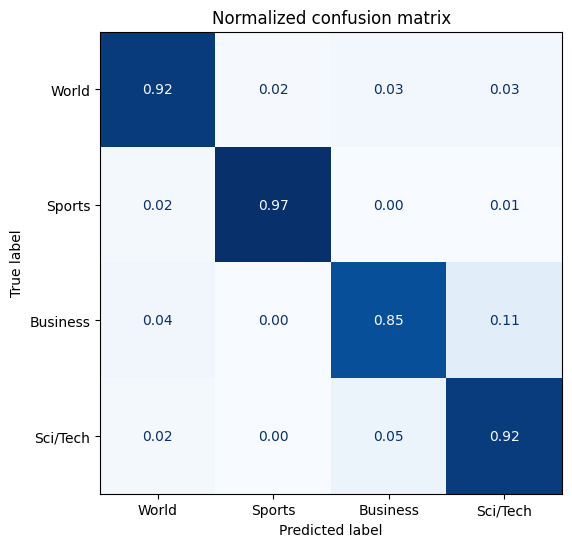

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Convert predicted labels to ids
label_to_id = {name: i for i, name in enumerate(label_names)}
pred_labels = [label_to_id[pred["label"]] for pred in model_preds]

# Compute confusion matrix
confusion_matrix = evaluate.load("confusion_matrix")
cm = confusion_matrix.compute(
    references=references, predictions=pred_labels, normalize="true"
)["confusion_matrix"]

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Normalized confusion matrix")
plt.show()

## Generating text


In [ ]:
filtered_datasets = raw_datasets.filter(lambda example: example["label"] == 2)
filtered_datasets = filtered_datasets.remove_columns("label")

Filter:   0%|          | 0/120000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7600 [00:00<?, ? examples/s]

### Training a Generative Model

In [ ]:
from transformers import AutoModelForCausalLM

model_id = "HuggingFaceTB/SmolLM-135M"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = (
    tokenizer.eos_token
)  # Needed as SmolLM does not specify padding token.
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

In [ ]:
def tokenize_function(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized_datasets = filtered_datasets.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],  # We only need the input_ids and attention_mask
)

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 30000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1900
    })
})

In [ ]:
from transformers import DataCollatorForLanguageModeling

# mlm corresponds to masked language modeling
# and we set it to False as we are not training a masked language model
# but a causal language model
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [ ]:
samples = [tokenized_datasets["train"][i] for i in range(3)]

for sample in samples:
    print(f"input_ids shape: {len(sample['input_ids'])}")

input_ids shape: 37
input_ids shape: 55
input_ids shape: 51


In [ ]:
out = data_collator(samples)
for key in out:
    print(f"{key} shape: {out[key].shape}")

input_ids shape: torch.Size([3, 55])
attention_mask shape: torch.Size([3, 55])
labels shape: torch.Size([3, 55])


In [ ]:
training_args = TrainingArguments(
    "business-news-generator",
    push_to_hub=True,
    per_device_train_batch_size=8,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    num_train_epochs=2,
    eval_strategy="steps",
    eval_steps=200,
    logging_steps=200,
)

In [ ]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"].select(range(5000)),
    eval_dataset=tokenized_datasets["test"],
)

In [ ]:
trainer.train()

  0%|          | 0/1250 [00:00<?, ?it/s]

{'loss': 3.66, 'grad_norm': 2.427961826324463, 'learning_rate': 0.0004690766700109659, 'epoch': 0.32}


  0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 3.5981976985931396, 'eval_runtime': 4.4414, 'eval_samples_per_second': 427.789, 'eval_steps_per_second': 53.586, 'epoch': 0.32}
{'loss': 3.319, 'grad_norm': 2.11116099357605, 'learning_rate': 0.00038395669874474915, 'epoch': 0.64}


  0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 3.486621618270874, 'eval_runtime': 4.5551, 'eval_samples_per_second': 417.119, 'eval_steps_per_second': 52.25, 'epoch': 0.64}
{'loss': 3.1101, 'grad_norm': 2.622725486755371, 'learning_rate': 0.0002656976298823284, 'epoch': 0.96}


  0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 3.3663034439086914, 'eval_runtime': 4.5256, 'eval_samples_per_second': 419.838, 'eval_steps_per_second': 52.59, 'epoch': 0.96}
{'loss': 2.1529, 'grad_norm': 2.4595162868499756, 'learning_rate': 0.00014355517710873183, 'epoch': 1.28}


  0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 3.443877696990967, 'eval_runtime': 4.5249, 'eval_samples_per_second': 419.902, 'eval_steps_per_second': 52.598, 'epoch': 1.28}
{'loss': 1.9697, 'grad_norm': 2.027958393096924, 'learning_rate': 4.7745751406263163e-05, 'epoch': 1.6}


  0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 3.4080607891082764, 'eval_runtime': 4.5391, 'eval_samples_per_second': 418.589, 'eval_steps_per_second': 52.434, 'epoch': 1.6}
{'loss': 1.9158, 'grad_norm': 2.5547542572021484, 'learning_rate': 1.9713246713805587e-06, 'epoch': 1.92}


  0%|          | 0/238 [00:00<?, ?it/s]

{'eval_loss': 3.397428274154663, 'eval_runtime': 4.6038, 'eval_samples_per_second': 412.703, 'eval_steps_per_second': 51.696, 'epoch': 1.92}
{'train_runtime': 139.9855, 'train_samples_per_second': 71.436, 'train_steps_per_second': 8.929, 'train_loss': 2.6575397399902343, 'epoch': 2.0}


TrainOutput(global_step=1250, training_loss=2.6575397399902343, metrics={'train_runtime': 139.9855, 'train_samples_per_second': 71.436, 'train_steps_per_second': 8.929, 'total_flos': 467451445248000.0, 'train_loss': 2.6575397399902343, 'epoch': 2.0})

In [ ]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/osanseviero/sft_extra/commit/fc112a32b79b379c8af88607db6b96f601d1c934', commit_message='End of training', commit_description='', oid='fc112a32b79b379c8af88607db6b96f601d1c934', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from transformers import pipeline

pipe = pipeline(
    "text-generation",
    model="genaibook/business-news-generator",
    device=device,
)
print(
    pipe("Q1", do_sample=True, temperature=0.1, max_new_tokens=30)[0][
        "generated_text"
    ]
)
print(
    pipe("Wall", do_sample=True, temperature=0.1, max_new_tokens=30)[0][
        "generated_text"
    ]
)
print(
    pipe("Google", do_sample=True, temperature=0.1, max_new_tokens=30)[0][
        "generated_text"
    ]
)

model.safetensors:  57%|#####6    | 283M/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/476 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/131 [00:00<?, ?B/s]

Q1-Gains on pace of increase in revenue -WSJ US insurers Q1 has doubled the number of claims for its insurance-insurance-busting service, in an effort to shift the burden of insurance onto its customers. Q1
Wall Street Gains on Labor Day (Reuters) Reuters - U.S. stocks gained in quiet trading\on Thursday following a sharp drop in oil prices, but gains continued\over the Labor Day holiday, with the market opening at a 45-
Google gets goaded down on profit warning LONDON: The European Commission has decided not to give Google Inc. its initial public offering a full price warning, saying the IPO deal lacked marketability. Google shares had their market debut Friday afternoon over fears it


## A Quick Introduction to Adapters

In [6]:
from peft import LoraConfig, get_peft_model

peft_config = LoraConfig(
    r=8, lora_alpha=32, lora_dropout=0.05, task_type="CAUSAL_LM"
)

model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM-135M")
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

trainable params: 460,800 || all params: 134,975,808 || trainable%: 0.3414


## A light introduction to quantization

In [15]:
model = AutoModelForCausalLM.from_pretrained("gpt2", torch_dtype=torch.float16)

In [16]:
import numpy as np

def scaling_factor(vector):
    # Get largest value of vector
    m = np.max(np.abs(vector))

    # Return scaling factor
    return 127 / m


array = [1.2, -0.5, -4.3, 1.2, -3.1, 0.8, 2.4, 5.4, 0.3]
alpha = scaling_factor(array)
quantized_array = np.round(alpha * np.array(array)).astype(np.int8)
dequantized_array = quantized_array / alpha

print(f"Scaling factor: {alpha}")
print(f"Quantized array: {quantized_array}")
print(f"Dequantized array: {dequantized_array}")
print(f"Difference: {array - dequantized_array}")

Scaling factor: 23.518518518518515
Quantized array: [  28  -12 -101   28  -73   19   56  127    7]
Dequantized array: [ 1.19055118 -0.51023622 -4.29448819  1.19055118 -3.10393701
  0.80787402  2.38110236  5.4         0.2976378 ]
Difference: [ 0.00944882  0.01023622 -0.00551181  0.00944882  0.00393701
 -0.00787402  0.01889764  0.          0.0023622 ]


In [ ]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(load_in_8bit=True)
model = AutoModelForCausalLM.from_pretrained(
    "gpt2", 
    quantization_config=quantization_config
)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


## Putting It All Together


In [ ]:
quantization_config = BitsAndBytesConfig(load_in_4bit=True)

model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-v0.3",
    quantization_config=quantization_config,
    device_map="auto",
)

In [ ]:
from trl import SFTConfig, SFTTrainer

dataset = load_dataset("timdettmers/openassistant-guanaco", split="train")

peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

sft_config = SFTConfig(
    "fine_tune_e2e",
    push_to_hub=True,
    per_device_train_batch_size=8,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    num_train_epochs=2,
    eval_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    gradient_checkpointing=True,
    max_seq_length=512,
    # New parameters
    dataset_text_field="text",
    packing=True,
)

trainer = SFTTrainer(
    model,
    args=sft_config,
    train_dataset=dataset.select(range(300)),
    peft_config=peft_config,
)

trainer.train()

In [ ]:
trainer.push_to_hub()

In [ ]:
# We load the base model just as before
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.3")
model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-v0.3",
    torch_dtype=torch.float16,
    device_map="auto",
)

# You can load the adapter with `load_adapter`
# Then load the model with `from_pretrained`.
model.load_adapter("genaibook/fine_tune_e2e")  # change with your adapter name

# Alternatively, you could just use `from_pretrained` with the adapter name and it
# will automatically take care of loading the base and adapter models.
# model = AutoModelForCausalLM.from_pretrained("genaibook/fine_tune_e2e"...

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
pipe("### Human: Hello!### Assistant:", max_new_tokens=100)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
pipe = pipeline(
    "text-generation", "HuggingFaceTB/SmolLM-135M-Instruct", device=device
)
messages = [
    {
        "role": "system",
        "content": """You are a friendly chatbot who always responds 
        in the style of a pirate""",
    },
    {
        "role": "user",
        "content": "How many helicopters can a human eat in one sitting?",
    },
]
print(pipe(messages, max_new_tokens=128)[0]["generated_text"][-1])

{'role': 'assistant', 'content': 'What a fascinating question!\n\nWhile it\'s impossible to provide an exact answer, I\'ll do my best to provide some insights based on historical records and expert opinions.\n\n**Historical records:**\n\nIn the 19th century, the concept of a "hippie" was popularized by the 1920s and 1930s, particularly in the United States. Hippies were a group of young people who rejected mainstream values and embraced alternative lifestyles, music, and culture. They were known for their love of psychedelic drugs, music, and alternative lifestyles.\n\nIn the 1'}


In [21]:
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M-Instruct")

chat = [
    {"role": "user", "content": "Hello, how are you?"},
    {
        "role": "assistant",
        "content": "I'm doing great. How can I help you today?",
    },
    {
        "role": "user",
        "content": "I'd like to show off how chat templating works!",
    },
]

tokenizer.apply_chat_template(chat, tokenize=False)

"<|im_start|>user\nHello, how are you?<|im_end|>\n<|im_start|>assistant\nI'm doing great. How can I help you today?<|im_end|>\n<|im_start|>user\nI'd like to show off how chat templating works!<|im_end|>\n"

In [22]:
print(tokenizer.apply_chat_template(chat, tokenize=False))

<|im_start|>user
Hello, how are you?<|im_end|>
<|im_start|>assistant
I'm doing great. How can I help you today?<|im_end|>
<|im_start|>user
I'd like to show off how chat templating works!<|im_end|>



## Solutions

A big part of learning is putting your knowledge into practice. We strongly suggest not looking at the solutions before taking a stab at the problem. Scroll down for th answers

### Exercises 

**1. What's the difference between base and fine-tuned models? What kind of model is a conversational one?** 

* **Base models:** Base models are models that are trained on a large dataset to perform general language modeling tasks. They serve as the model that can be further adapted to specific tasks.
* **Fine-tuned models:**  Fine-tuned models are derived from base models by training them further on a smaller, more specific dataset tailored for a particular task or domain. Fine-tuning adjusts the pretrained model's parameters to enhance its performance in specialized areas. Examples include models fine-tuned for summarization, text classification, named entity recognition, and more.
* **Conversational models:** Conversational models are a type of fine-tuned model specifically trained to generate responses in a conversational context. These models are fine-tuned on datasets composed of dialogue or chat-like interactions, enabling them to produce coherent replies in a conversational setting.

**2. In which cases would you pick a base encoder model for fine-tuning?**

Fine-tuning often makes sense when dealing with tasks that require understanding, such as classification, named entity recognition, and question answering. Encoder models, like BERT, usually shine due to their ability to produce contextual embeddings and their computational efficiency. BERT models are often used as base models for fine-tuning because they provide a strong foundation for a wide range of NLP tasks.

However, there are cases where a base encoder model might be sufficient without fine-tuning:

* **Strong Zero-shot or Few-shot capabilities** In such cases, the base model can be used directly to achieve good performance on specific tasks without additional training.
* **Resource constraints** Fine-tuning requires additional computational resources and time.
* **General tasks** For tasks that are either generic or too similar to the pre-training objectives, the base model might perform sufficiently well without fine-tuning.

**3. Explain the differences between fine-tuning, instruct-tuning, and QLoRA.**

* **Fine-tuning:** Pick a pre-trained model and keep training to adapt/specialize it on a task or domain. The model's parameters are adjusted to improve its performance on the target task.
* **Instruct-tuning:** A type of fine-tuning in which an instruct dataset is used. This dataset can formulate different tasks as instructions, helping the model generalize to solve new tasks.
* **QLoRA:** LoRA is a type of fine-tuning in which just an adapter (an additional small set of parameters) is modified while the base model is frozen. QLoRA is a variant of LoRA that uses quantization to quantize the base model and hence require less GPU memory.

**4. Does using adapters lead to a larger model size?**

Adapters initially add a very small overhead to the model size. Fortunately, we can merge back the adapter weights to the base model, going back to the original size. To achieve this, you can use `merge_and_unload`.

**5. How much GPU memory is needed to load a 70B model in half-precision, 8-bit quantization, and 4-bit quantization?**

A quick (not extremely precise, but gives a good idea of order of magnitude):

* **Full Precision**: 32-bits (4 bytes) for each of the 70B params. 70B * 4 bytes = 280 GB
* **Half Precision**: 16-bits (2 bytes) for each of the 70B params. 70B * 2 bytes = 140 GB
* **8-bit Quantization**: 8-bits (1 byte) for each of the 70B params. 70B * 1 byte = 70 GB
* **4-bit Quantization**: 4-bits (0.5 bytes) for each of the 70B params. 70B * 0.5 bytes = 35 GB

Note: there's usually an additional overhead of other things being loaded into the GPU.

**6. Why does QLoRA lead to slower training?** 

QLoRA decreases the memory requirements but increases the computational overhead due to additional quantization and dequantization steps during training. These extra steps require additional computation, leading to slower training.

**7. In which cases do we freeze the model weights during fine-tuning?**

In the context of transformers fine-tuning, the traditional process does not freeze the model weights. However, there are cases where freezing the model weights can be beneficial, such as PEFT or using the model as a feature extractor. Sometimes, you might want to use the pre-trained model as a feature extractor. In such cases, you freeze the model weights and use the model to extract features for downstream tasks. For example, you might want to connect a traditional model (e.g. SVM, Random Forest) to the transformer model's output. If you have very limited data, it might make sense to freeze most of the model and only fine-tune the last layers.

### Challenges

**8. Image Classification** Although this chapter has focused on fine-tuning transformer models for NLP tasks, transformers can also be used for other modalities such as audio and Computer Vision. The goal of this challenge is to fine-tune a transformer model for image classification. We suggest to:

* Use a pre-trained vision transformer model such as [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k).
* Use a dataset of images and labels such as [food101](https://huggingface.co/datasets/food101).


The `food101` dataset contains 101 food categories, with a total of 101,000 images. We'll just use a small subset of the data (5,000 images) to validate that the fine-tuning process works. Feel free to use more data and run additional experiments!

In [22]:
from datasets import load_dataset

food = load_dataset("food101", split="train[:5000]")

In [23]:
food

Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})

Let's create train and test splits out of this dataset. 

In [24]:
food = food.train_test_split(test_size=0.2, seed=42)

In [25]:
sample = food["train"][1]
sample 

{'image': <PIL.Image.Image image mode=RGB size=512x512>, 'label': 6}

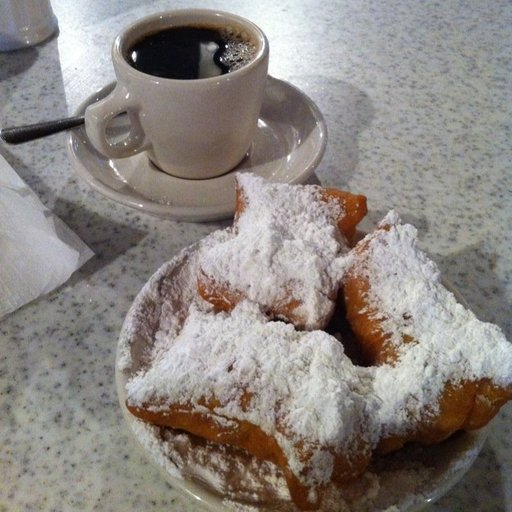

In [26]:
sample["image"]

That looks tasty. What is it? What does label 6 correspond to in the dataset?

In [27]:
labels = food["train"].features["label"].names
labels[6]

'beignets'

Yummy! Note that the 5,000 samples in our subset of the dataset don't represent the 101 categories, but just a few of them. Let's see what we have in the train and test sets:

In [28]:
import numpy as np
np.unique(np.array(food["train"]["label"]), return_counts=True)

(array([ 6, 10, 20, 53, 77, 79, 81]),
 array([611, 607, 596, 602, 389, 584, 611]))

In [29]:
np.unique(np.array(food["test"]["label"]), return_counts=True)

(array([ 6, 10, 20, 53, 77, 79, 81]),
 array([139, 143, 154, 148, 111, 166, 139]))

We only have 7 classes out of the 101 in the original dataset. We'll train our classifier so it learns to recognize photos among those 7 classes. To do so, we need to use class ids between 0 and 6, and not the original numbers we see above. This is because the classifier will select the chosen class based on the order of the output cell whose probability is larger, so numbers must be correlative and start at 0.

An alternative would be to pass the 101 classes as potential outputs but only use examples for the 7 classes in the subset. The model will still learn (you can verify it yourself!), but it will be slightly harder for it :)

Let's then create dictionaries from the new labels to the class names and vice versa. We'll also create a mapping from the original label ids (all the classes in the dataset) to the new ones between 0 and 6 we are fine-tuning for.

In [44]:
label2id, id2label, original2id = dict(), dict(), dict()
finetuning_label_ids = np.unique(np.array(food["test"]["label"]))
for i, old_label_id in enumerate(finetuning_label_ids):
    label = labels[old_label_id]
    label2id[label] = str(i)
    id2label[str(i)] = label
    original2id[old_label_id] = i

In [37]:
id2label

{'0': 'beignets',
 '1': 'bruschetta',
 '2': 'chicken_wings',
 '3': 'hamburger',
 '4': 'pork_chop',
 '5': 'prime_rib',
 '6': 'ramen'}

Let's now pre-process the dataset. We'll use an `AutoImageProcessor` rather than an `AutoTokenizer` to preprocess the images. Just as with tokenizers, the processor is tied to a model. This ensures we pass images in the right format to the model.

In [38]:
from transformers import AutoImageProcessor

model_id = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_id)

/home/pedro/miniconda3/envs/genai/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


If you take a look at the [preprocessor configuration](https://huggingface.co/google/vit-base-patch16-224-in21k/blob/main/preprocessor_config.json), you'll see that it resizes the input image to a size of 224x224 and normalizes so that input values are between -1 and 1. It can also take care of converting the input PIL images to PyTorch tensors:

In [39]:
preprocessed = image_processor(images=[sample["image"]], return_tensors="pt")["pixel_values"][0]
preprocessed.shape, preprocessed.min(), preprocessed.max()

(torch.Size([3, 224, 224]), tensor(-1.), tensor(1.))

We'll use the built-in processor to make sure that input data follows the same transformations that were applied during pre-training. Alternatively, you could explore other transformations if they make sense for your task, such as cropping to square sizes before resizing (if keeping the aspect ratio is important for your task), or performing data augmentation.

Another step of the transformation is to map the original class ids to the new ones.

In [52]:
def preprocess(examples):
    examples.update(image_processor(examples["image"], return_tensors="pt"))
    examples["label"] = [original2id[x] for x in examples["label"]]
    del examples["image"]
    return examples

In [53]:
food = food.with_transform(preprocess)

We'll also use the `DefaultDataCollator` to collate the data into batches. This collator does not apply any preprocessing - it just batches the data. It can be used in situations where, like in our case, all input tensors already have the same shape.

In [55]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

We'll evaluate the model with the accuracy metric.

In [56]:
from transformers import Trainer, TrainingArguments
import evaluate

In [57]:
accuracy = evaluate.load("accuracy")

In [58]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

Finally, let's load the base model. Although not strictly needed, we can add `id2label` and `label2id` to the model. This will help us convert between class names and labels and add this information to the model `config.json` file.

In [71]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    model_id,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Let's now train! Things are similar as before.

In [72]:
batch_size = 32 # change according to GPU

training_args = TrainingArguments(
    "my-food-model",
    num_train_epochs=3,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=5e-5,
    gradient_accumulation_steps=1,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True, 
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.427200,0.437326,0.927000
2,0.219900,0.300362,0.936000
3,0.130100,0.268910,0.938000


TrainOutput(global_step=375, training_loss=0.4868399291038513, metrics={'train_runtime': 169.3039, 'train_samples_per_second': 70.878, 'train_steps_per_second': 2.215, 'total_flos': 9.29945547546624e+17, 'train_loss': 0.4868399291038513, 'epoch': 3.0})

We got a test accuracy of almost 94% in three epochs.

In [73]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/pcuenq/my-food-model/commit/f56fc3a62c49f047aedc41b2aae8646bdf60d895', commit_message='End of training', commit_description='', oid='f56fc3a62c49f047aedc41b2aae8646bdf60d895', pr_url=None, pr_revision=None, pr_num=None)

Let's now use the `image-classification` pipeline and try to classify the image from the beginning.

In [74]:
from transformers import pipeline

classifier = pipeline("image-classification", model="pcuenq/my-food-model")
classifier(sample["image"])

config.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

[{'label': 'beignets', 'score': 0.9071165919303894},
 {'label': 'hamburger', 'score': 0.01748700812458992},
 {'label': 'ramen', 'score': 0.017378924414515495},
 {'label': 'prime_rib', 'score': 0.01568443886935711},
 {'label': 'chicken_wings', 'score': 0.014900492504239082}]

Nice! Feel free to explore:

* Find samples from the validation set for which the model is very confident but mismatches the label. Which one is right?
* Try using other models, such as Swin Transformer, MobileViT or ConvNNeXT.
* Explore creating your own dataset with just 3 clases and 10 images per class. How does the model perform?